<a href="https://colab.research.google.com/github/choobrendan/Flag-Guesser/blob/main/flag_guess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from keras.layers import LeakyReLU
from PIL import Image
keras = tf.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp  /content/Flags.zip
!unzip PetImages.zip

cp: missing destination file operand after '/content/Flags.zip'
Try 'cp --help' for more information.
unzip:  cannot find or open PetImages.zip, PetImages.zip.zip or PetImages.zip.ZIP.


In [ ]:
gpus = tf.config.experimental.list_physical_devices('CPU')


In [ ]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices ('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth (gpu, True)

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
data_dir=r"/content/drive/MyDrive/Flags"

In [ ]:
image_exts=["jpeg","jpg","bmp","png","gif"]

In [ ]:
num_classes=len(os.listdir(r"/content/drive/MyDrive/Flags"))

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                # Convert the image to JPG format
                img = Image.open(image_path)
                new_image_path = os.path.splitext(image_path)[0] + ".jpg"
                img.convert("RGB").save(new_image_path, "JPEG")
                os.remove(image_path)  # Remove the original non-image file
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [ ]:
import numpy as np

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,         # Randomly zoom images by 20%
    width_shift_range=0.1,  # Randomly shift images horizontally by 10%
    height_shift_range=0.1, # Randomly shift images vertically by 10%
    rotation_range=5,      # Randomly rotate images by up to 20 degrees
    brightness_range=(0.7, 1.3),  # Randomly adjust brightness between 0.8 and 1.2
    shear_range=0.2,        # Randomly apply shearing transformations
    horizontal_flip=False,   # Randomly flip images horizontally
    vertical_flip=False      # Randomly flip images vertically
)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',  # This indicates multiclass classification
    seed=42,  # Set the seed for reproducibility
    image_size=(256, 256),
    batch_size=32
)

Found 4495 files belonging to 26 classes.


In [ ]:
data=data.map(lambda x,y:(x/255,y))

In [ ]:
scaled_iterator=data.as_numpy_iterator()

In [ ]:
batch=scaled_iterator.next()

In [ ]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = int(len(data) * 0.1)

In [ ]:
train=data.take (train_size)
val = data.skip(train_size).take(val_size)
test=data.skip (train_size+val_size).take(test_size)

In [ ]:
# def preprocess_image(image_path):
#     img = cv2.imread(image_path)
#     tip = imghdr.what(image_path)
#     if tip not in image_exts:
#         print('Image not in ext list {}'.format(image_path))
#         os.remove(image_path)
#         return None
#     # Convert to 8-bit unsigned integers
#     img = cv2.convertScaleAbs(img)
#     return img

In [ ]:
import tensorflow as tf

# Define the data augmentation function
def augment_image(image, label):
    # Randomly adjust brightness, contrast, saturation, and hue
    image = tf.image.random_brightness(image, max_delta=0.02)
    image = tf.image.random_contrast(image, lower=0.99, upper=1.01)
    image = tf.image.random_saturation(image, lower=0.99, upper=1.01)
    image = tf.image.random_hue(image, max_delta=0.01)
    # Add more augmentation techniques as per your requirement
    # For example, you can use tf.image.random_flip_left_right for random horizontal flipping, etc.

    return image, label

# Define the preprocess function without resizing to use it later for validation and test sets
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)  # Convert to 8-bit unsigned int
    image = tf.image.resize(image, (256, 256))
    image =image/255.0# Resize to model input size
    return image, label

# # Apply duplication and augmentation to the training data
# def augment_and_duplicate(image, label, num_duplicates=1):
#     # List to store augmented images and labels
#     augmented_images = []
#     augmented_labels = []

#     # Add original image and label to the lists
#     augmented_images.append(image)
#     augmented_labels.append(label)

#     # Apply augmentation and add duplicates to the lists
#     for _ in range(num_duplicates):
#         augmented_image, augmented_label = augment_image(image, label)
#         augmented_images.append(augmented_image)
#         augmented_labels.append(augmented_label)

#     # Stack the lists to create tensors
#     augmented_images = tf.stack(augmented_images)
#     augmented_labels = tf.stack(augmented_labels)

#     return augmented_images, augmented_labels

# # Duplicate and augment the training data
# num_duplicates = 2 # You can adjust the number of duplicates as per your requirement
# train = train.flat_map(lambda image, label: tf.data.Dataset.from_tensor_slices(augment_and_duplicate(image, label, num_duplicates)))
train = train.map(preprocess_image)
# Apply preprocessing to validation and test sets
val = val.map(preprocess_image)
test = test.map(preprocess_image)


In [ ]:
train.as_numpy_iterator().next()[0]

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[0.85490197, 0.85490197, 0.85490197],
         [0.84705883, 0.84705883, 0.84705883]

In [ ]:
model=Sequential()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (7, 7), 1, activation=keras.layers.LeakyReLU(alpha=0.2), input_shape=(256, 256, 3)))
model.add(MaxPooling2D())


# Second convolution layer with increased filters, Dropout, and Regularization
model.add(Conv2D(64, (5, 5), strides=1, activation=keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(MaxPooling2D())

# Third convolution layer with increased filters and BatchNormalization
model.add(Conv2D(64, (3, 3), strides=1, activation=keras.layers.LeakyReLU(alpha=0.05), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Third convolution layer with increased filters and BatchNormalization
model.add(Conv2D(32, (3, 3), strides=1, activation=keras.layers.LeakyReLU(alpha=0.05), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Flatten the output to feed into the dense layers
model.add(Flatten())

# Dense layers with Dropout and Regularization
model.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer for multiclass classification
model.add(Dense(num_classes, activation='softmax'))

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      4736      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 121, 121, 64)      51264     
                                                                 
 dropout_2 (Dropout)         (None, 121, 121, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)       

In [ ]:
logdir='logs'

In [ ]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist=model.fit(train, epochs=500, validation_data=val, callbacks =[tensorboard_callback,early_stopping])

Epoch 1/500
112/112 [==============================] - 48s 378ms/step - loss: 7.6366 - accuracy: 0.6124 - val_loss: 6.9325 - val_accuracy: 0.4531
Epoch 2/500
112/112 [==============================] - 44s 384ms/step - loss: 5.0306 - accuracy: 0.7991 - val_loss: 4.2049 - val_accuracy: 0.8103
Epoch 3/500
112/112 [==============================] - 43s 379ms/step - loss: 3.4620 - accuracy: 0.8538 - val_loss: 3.2906 - val_accuracy: 0.7679
Epoch 4/500
112/112 [==============================] - 47s 410ms/step - loss: 2.6331 - accuracy: 0.8675 - val_loss: 2.4877 - val_accuracy: 0.8326
Epoch 5/500
112/112 [==============================] - 43s 379ms/step - loss: 2.2741 - accuracy: 0.8652 - val_loss: 2.4225 - val_accuracy: 0.7879
Epoch 6/500
112/112 [==============================] - 44s 384ms/step - loss: 1.9000 - accuracy: 0.8984 - val_loss: 2.1795 - val_accuracy: 0.7634
Epoch 7/500
112/112 [==============================] - 45s 390ms/step - loss: 1.5934 - accuracy: 0.9102 - val_loss: 1.5821 -

1/1 [==============================] - 0s 34ms/step


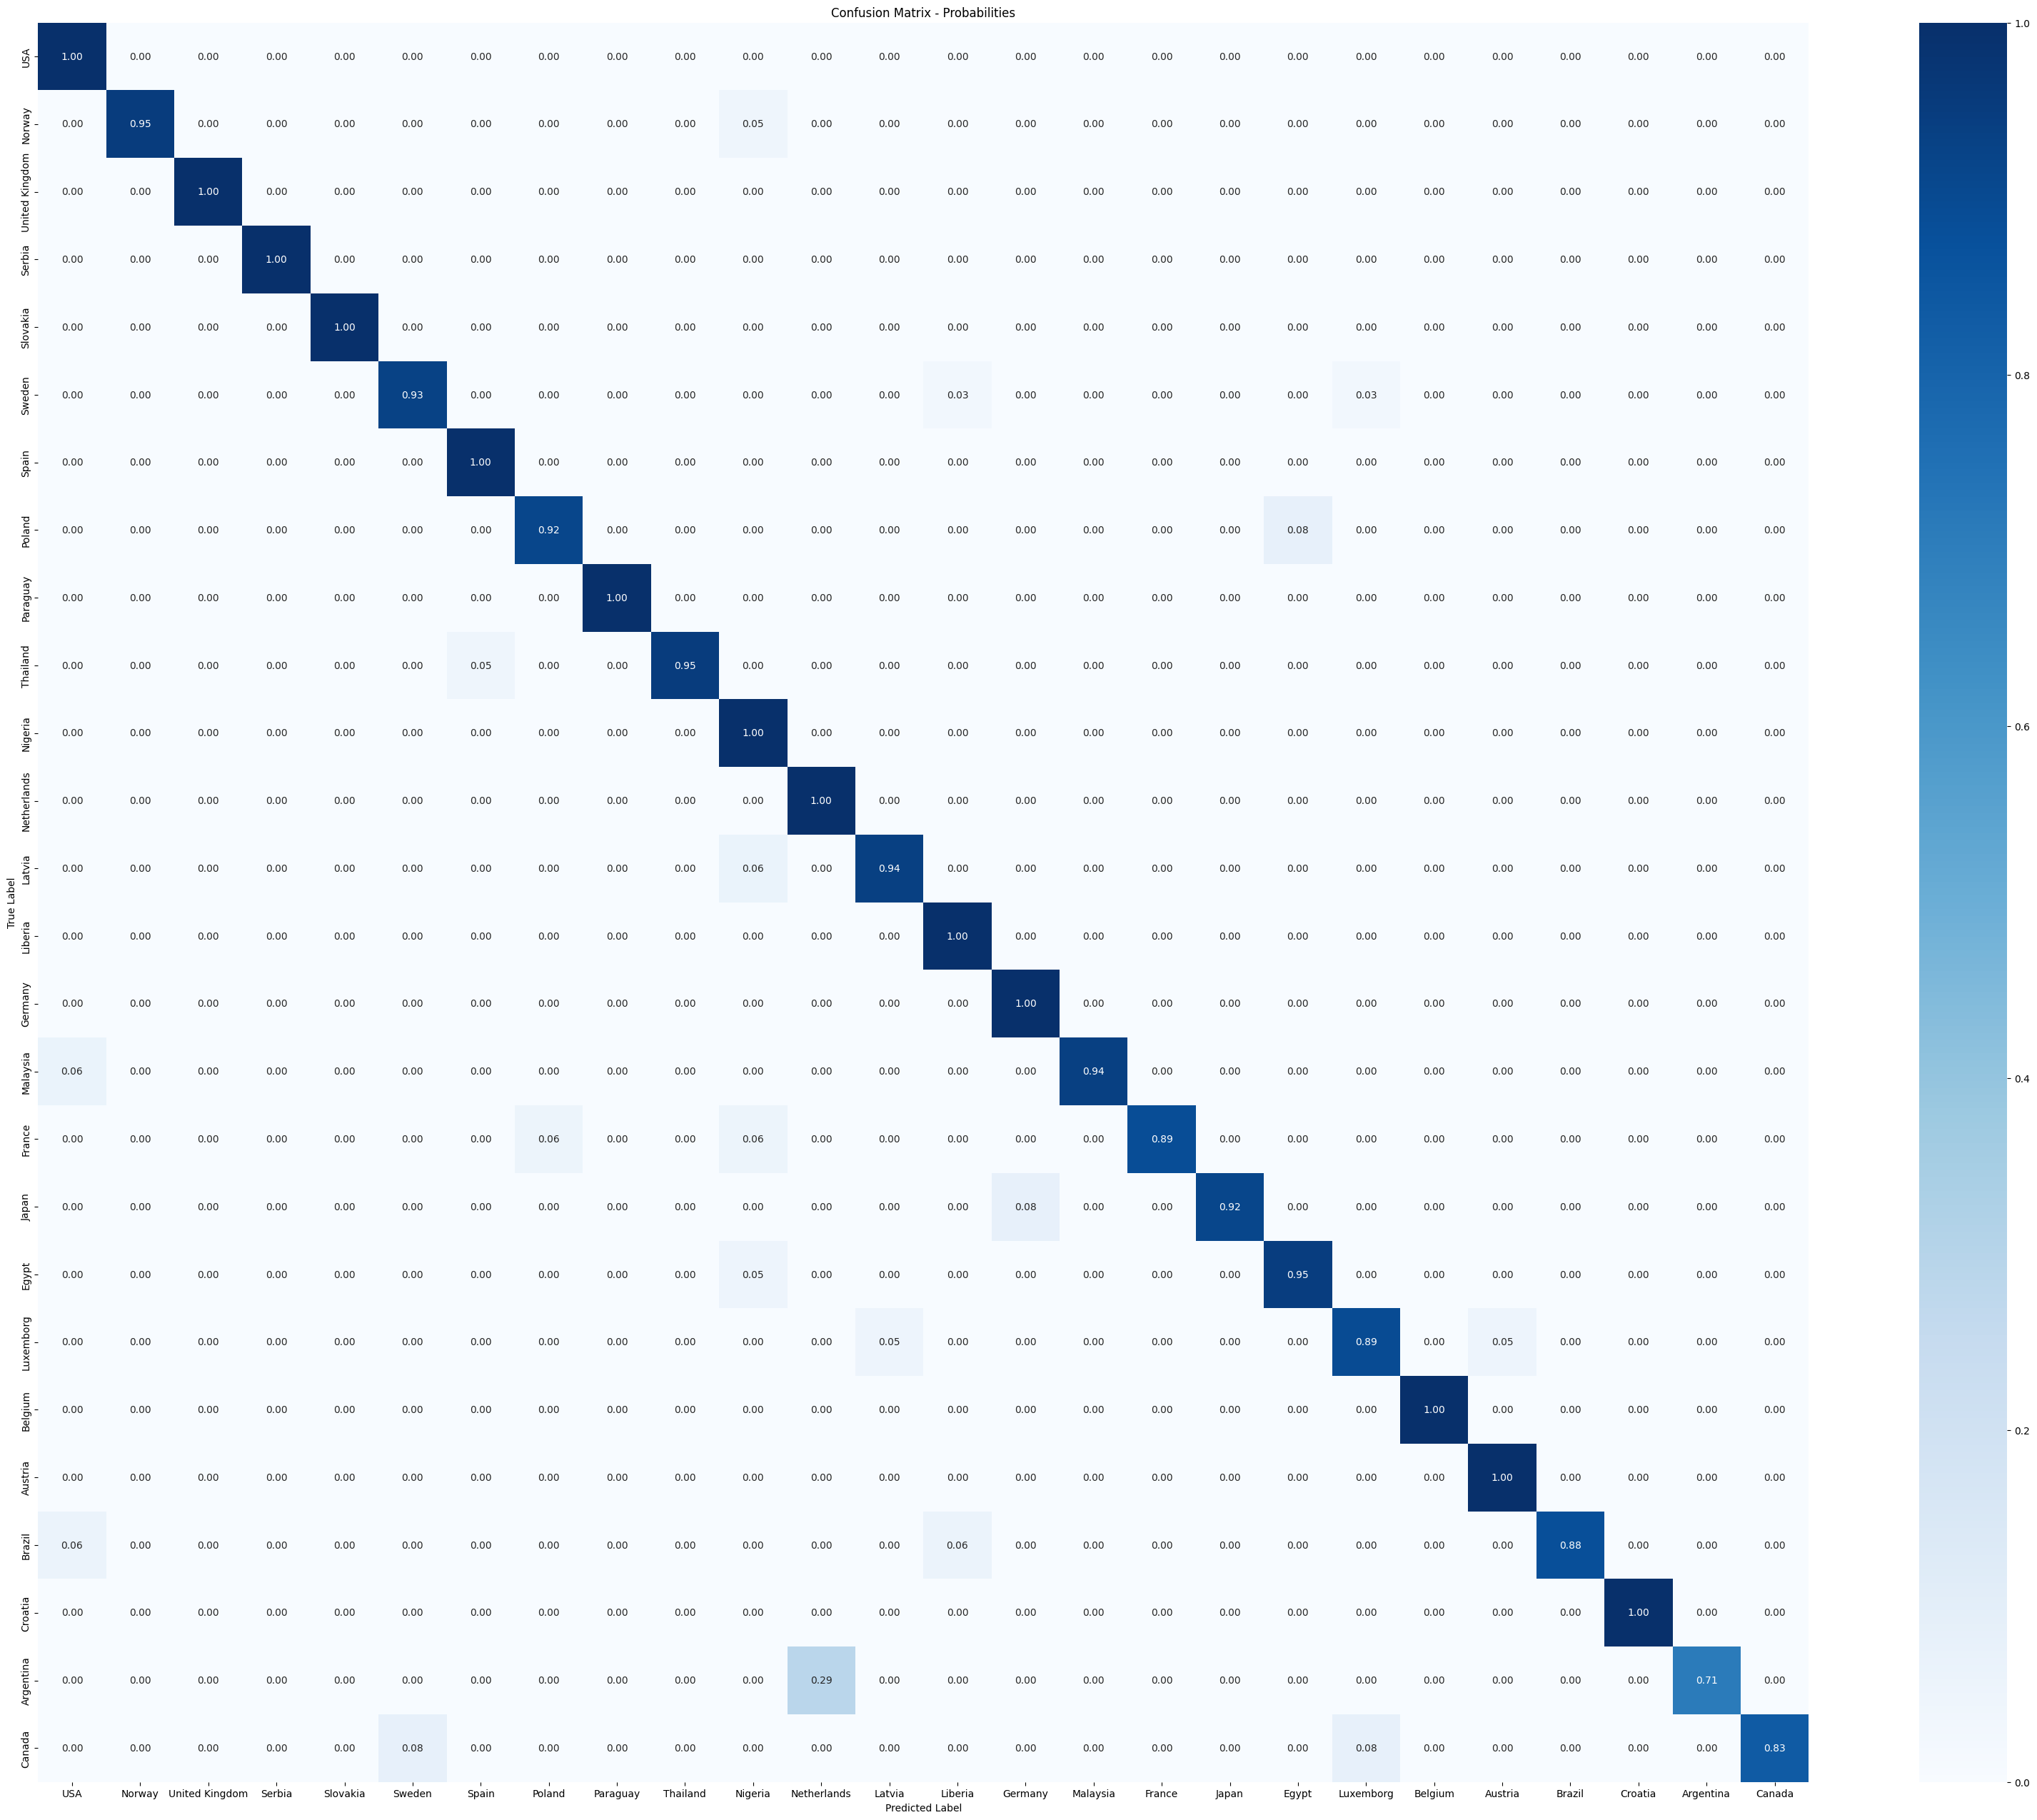

Classification Report:
                precision    recall  f1-score   support

           USA       0.88      1.00      0.93        14
        Norway       1.00      0.95      0.97        20
United Kingdom       1.00      1.00      1.00        16
        Serbia       1.00      1.00      1.00        21
      Slovakia       1.00      1.00      1.00        24
        Sweden       0.97      0.93      0.95        30
         Spain       0.93      1.00      0.96        13
        Poland       0.92      0.92      0.92        12
      Paraguay       1.00      1.00      1.00        11
      Thailand       1.00      0.95      0.97        20
       Nigeria       0.83      1.00      0.91        20
   Netherlands       0.91      1.00      0.95        20
        Latvia       0.94      0.94      0.94        16
       Liberia       0.88      1.00      0.94        15
       Germany       0.88      1.00      0.94        15
      Malaysia       1.00      0.94      0.97        16
        France       1.0

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Assuming you have already trained the model and have the test dataset
# (or you can use 'test' set if you have already created it)

# Get the true labels and predicted labels from the test set
y_true = []
y_pred = []
for images, labels in test:
    y_true.extend(np.argmax(labels, axis=1))  # Get the true class indices
    y_pred.extend(np.argmax(model.predict(images), axis=1))  # Get the predicted class indices

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix to show probabilities instead of counts
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
class_names = os.listdir(r"/content/drive/MyDrive/Flags")
# Plot the heatmap
plt.figure(figsize=(40, 32))
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Probabilities')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# If you want a classification report (precision, recall, F1-score, etc.), you can use the following:

report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)

1/1 [==============================] - 0s 29ms/step


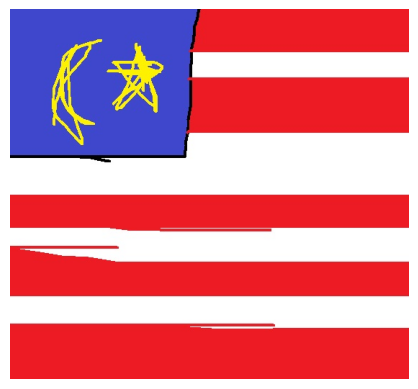

Predicted Class Index: 13
Predicted Class Name: Malaysia
Predicted Class Confidence: 1.0


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
new_image_path = r"/content/sample_data/TestImage.jpg"  # Replace with the path to your new image

i=23
# Load and preprocess the new image
new_image = cv2.imread(new_image_path)
new_image = cv2.convertScaleAbs(new_image)
new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
new_image = tf.image.convert_image_dtype(new_image, dtype=tf.uint8)
resize= tf.image.resize(new_image,(256,256))
# new_image = new_image / 255.0  # Normalize pixel values to [0, 1]
predictions=model.predict(np.expand_dims(resize,axis=0))
# Convert the image to a supported depth (e.g., 8-bit unsigned integers)

#  # Add batch dimension

# View the new image
plt.imshow(new_image.numpy().squeeze())
plt.axis('off')
plt.show()

predicted_class_index = np.argmax(predictions[0])
predicted_class_name = predicted_class_name = sorted(os.listdir(r"/content/drive/MyDrive/Flags"))[predicted_class_index] # Assuming class indices are integers starting from 0

# Print the predicted class index and name
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)
print("Predicted Class Confidence:", predictions[0][np.argmax(predictions[0])])
predictions


In [ ]:
a=os.listdir(r"/kaggle/input/flag-pictures-dataset/Flags")
sorted(a)

In [ ]:
predictions

In [ ]:


batch[2][31]

In [ ]:
new_image

In [ ]:


# Convert the image to a supported depth (e.g., 8-bit unsigned integers)
image = cv2.convertScaleAbs((new_image/(255)).numpy(), alpha=(255.0))
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = np.expand_dims(image, axis=0)  # Add batch dimension

# View the new image
plt.imshow(cv2.cvtColor(image.squeeze(), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
model.save(r"/content/drive/MyDrive")

In [ ]:
modelsaved = tf.keras.models.load_model(r"/content/sequential_3")

1/1 [==============================] - 0s 162ms/step


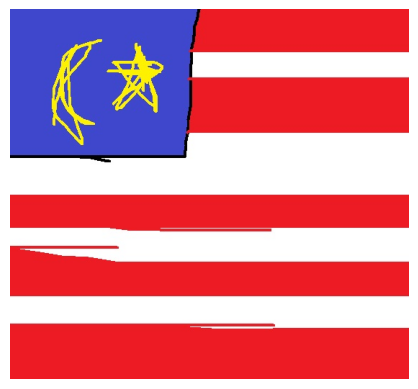

Predicted Class Index: 13
Predicted Class Name: Malaysia
Predicted Class Confidence: 1.0


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
%cd /content/sequential_3

/content/sequential_3


In [ ]:
!zip -r sequential_3.zip /content/sequential_3/


  adding: content/sequential_3/ (stored 0%)
  adding: content/sequential_3/fingerprint.pb (stored 0%)
  adding: content/sequential_3/saved_model.pb (deflated 89%)
  adding: content/sequential_3/keras_metadata.pb (deflated 93%)
  adding: content/sequential_3/variables/ (stored 0%)
  adding: content/sequential_3/variables/variables.index (deflated 67%)
  adding: content/sequential_3/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/sequential_3/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download(r'/content/sequential_3/sequential_3.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>